In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

import sys
sys.path.append("../../../neuroprob/")

import neuroprob as mdl
from neuroprob import utils


import pickle


dev = utils.pytorch.get_device()



plt.style.use(['paper.mplstyle'])

PyTorch version: 1.7.1+cu101
Using device: cuda:0


### Data preparation

In [3]:
sample_bin, track_samples, x_t, y_t, emp_s_t, dir_t, \
    hd_t, eeg_t, theta_t, pause_ind, pause_size, \
    sep_t_spike, clu_id, t_spike, spike_samples, units, \
    shank_id, local_clu, FR_waveshape, SpkWidthC, \
    refract_viol, isolation_dist, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('../data/datasets/hc5_13.p', 'rb'))


In [15]:
vx_t = (x_t[1:]-x_t[:-1])/sample_bin
vy_t = (y_t[1:]-y_t[:-1])/sample_bin

s_t = np.sqrt(vx_t**2 + vy_t**2)

max_speed = s_t.max()
wrap_theta_t = utils.signal.WrapPi(theta_t, True)
behav_data = (x_t, y_t, wrap_theta_t)


left_a = x_t.min()
right_a = x_t.max()
bottom_a = y_t.min()
top_a = y_t.max()

In [9]:
# Fit to subset of neurons
unit_used = np.arange(30)
units_used = len(unit_used)
used_t_spike = [sep_t_spike[u] for u in unit_used]
#behav_data = (x_t, y_t, wrap_theta_t)


bin_size = 1
tbin, _, syn_train, _ = utils.neural.bin_data(bin_size, sample_bin, used_t_spike, track_samples)

neurons = syn_train.shape[0]
#track_samples = syn_train.shape[-1]

In [11]:
# rebin data
datasets = []
bin_sizes = [10, 20, 30, 50, 70, 100, 125, 200, 400]

for bin_size in bin_sizes:
    tbin, resamples, rc_t, rbehav = utils.neural.bin_data(bin_size, sample_bin, used_t_spike, 
                                                          track_samples, behav_data, average_behav=False, binned=False)
    
    datasets.append((tbin, resamples, rc_t, rbehav))


In [ ]:
binnings = 10
folds = 5


fit_set, valid_set = neural_utils.SpikeTrainCV(folds, used_t_spike, track_samples, behav_data)
cv_set = []
for f, v in zip(fit_set, valid_set):
    _, v_size, v_spk, _ = \
            neural_utils.BinTrain(bin_size, sample_bin, v[0], len(v[1][0]), _)
    cv_set.append((f[1], f[0], v[1], v_spk, v_size))
    

### Model fitting

In [12]:
loss_arr = []

In [ ]:
for dd in datasets:
    tbin, resamples, rc_t, rbehav = dd
    rx_t, ry_t, rwrap_theta_t = rbehav
    ini_X = [rx_t, ry_t, rwrap_theta_t]

    
    # GP model
    l = 10.*np.array([np.ones(2)]).T
    l_ang = 4.*np.array([np.ones(1)])
    v = np.ones(neurons)
    kernels_tuples = [('variance', v), ('RBF', 'euclid', l), ('RBF', 'torus', l_ang)]
    VI_tuples = [(None, None, None, 1), (None, None, None, 1), (None, None, None, 1)]
    in_dims = 3


    num_induc = 8
    U = np.concatenate([
        np.linspace(left_a, right_a, num_induc)[None, :, None],
        np.linspace(bottom_a, top_a, num_induc)[None, :, None],
        np.linspace(0, 2*np.pi, num_induc+1)[None, :-1, None], 
    ], axis=-1)
    inducing_points = U.repeat(neurons, axis=0)

    gpr = mdl.nonparametrics.Gaussian_process(
        in_dims, neurons, kernels_tuples, inducing_points=inducing_points, 
        inv_link='exp', whiten=True, jitter=1e-4, mean=np.zeros(neurons), learn_mean=True
    )

    gpd = mdl.nonparametrics.Gaussian_process(
        in_dims, neurons, kernels_tuples, inducing_points=inducing_points, 
        inv_link='exp', whiten=True, jitter=1e-4, mean=np.zeros(neurons), learn_mean=True
    )


    inputs = mdl.inference.input_group(in_dims, VI_tuples)
    inputs.set_XZ(ini_X, resamples, batch_size=5000, filter_len=1)  

    likelihood = mdl.likelihoods.Poisson(tbin, neurons, 'exp')
    #r_inv = 10.*np.ones(neurons)
    #likelihood = mdl.likelihoods.Negative_binomial(sample_bin, neurons, 'exp', r_inv)
    #alpha = .1*np.ones(neurons)
    #likelihood = mdl.likelihoods.ZI_Poisson(sample_bin, neurons, 'exp', alpha, dispersion_mapping=None)
    
    
    likelihood = mdl.likelihoods.Universal(inner_dims//C, C, 'identity', cutoff, mapping_net)
    likelihood.set_Y(rc_t, batch_size=5000, filter_len=1) 


    glm = mdl.inference.VI_optimized(inputs, gpr, likelihood)
    glm.to(dev)



    # fitting
    sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
    opt_tuple = (optim.Adam, 100, sch)
    opt_lr_dict = {'default': 1e-2}

    glm.set_optimizers(opt_tuple, opt_lr_dict)

    annealing = lambda x: 1.0#min(1.0, 0.005*x)
    losses = glm.fit(3000, loss_margin=0.0, margin_epochs=100, kl_anneal_func=annealing, 
                     cov_samples=1, ll_samples=10, ll_mode='MC')

    loss_arr.append(losses)
    plt.figure()
    plt.plot(losses)
    plt.xlabel('epoch')
    plt.ylabel('NLL per time sample')
    plt.show()

In [26]:
ll = np.array([l[-1] for l in loss_arr])
#nt = np.array([dd[1] for dd in datasets])
ct = np.array([dd[2].sum(-1) for dd in datasets])
ts = np.array([dd[0] for dd in datasets])
#ratio = -ll - ct.sum(-1)*np.log(ts)

Text(0.5, 0, 'bin size (ms)')

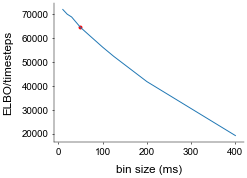

In [111]:
plt.plot(bin_sizes, ratio)
plt.scatter(bin_sizes[3], ratio[3], c='r')

#plt.plot(bin_sizes, 20*np.log(bin_sizes)-30, 'k--')

plt.ylabel('ELBO/timesteps')
plt.xlabel('bin size (ms)')

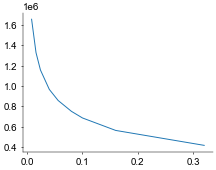

In [28]:
# Poisson
plt.plot(ts, ll)

### Point process

In [ ]:
# GP fit and compare lengthscales
num_induc = 30
inducing_points = np.array([left_x + arena_width*np.random.rand(num_induc), \
                            bottom_y + arena_height*np.random.rand(num_induc)]).T[None, ...].repeat(units_used, axis=0)

l = np.ones(units_used)
v = np.ones(units_used)


kt = [('RBF', 'euclid', np.array([l, l]), v)]

glm_rate = mdl.nonparametrics.GP_covariates(units_used, inducing_points, kt, ([None],)*2, ([None],)*2, 
                                            inv_link='exp', shared_kernel_params=False, 
                                            jitter=1e-4, mean_ini=np.zeros((1, units_used, 1)))
glm_rate.set_params(sample_bin)

likelihood = mdl.likelihoods.Poisson(units_used, 'exp')
likelihood.set_params(sample_bin)

# NLL model
hist_len = 99 # 100 steps of spiketrain, no instantaneous element
hist_couple = mdl.filters.GP_filter(units_used, units_used, hist_len, sample_bin)

glm = mdl.inference.nll_optimized([glm_rate], likelihood, spk_couple=hist_couple)
glm.preprocess([r for r in rbehav_t[:2]], resamples, rc_t, batch_size=10000)
glm.to(dev)


# fit
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {'default': 1e-2}
glm.set_optimizers(opt_tuple, opt_lr_dict)

annealing = lambda x: min(1.0, 0.005*x)
losses = glm.fit(1000, margin=1e0, anneal_func=annealing)

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()